In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json, copy, pickle
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, get_sun
from astropy.coordinates import Angle
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
from alerts import get_alerts
from style import output_folder, big_fontsize, base_width, base_height, dpi, CB_color_cycle
import seaborn as sns
from astropy.time import Time

from scipy.optimize import root
from scipy.interpolate import interp1d
from scipy.integrate import quad

from flarestack.cosmo import get_rate, define_cosmology_functions
plt.style.use('tableau-colorblind10')

No scratch directory has been set. Using home directory as default.


In [3]:
alerts = get_alerts()

In [4]:
m = alerts['observed'] & (~alerts.retracted)
observed = alerts[m]

In [5]:
N = len(observed.Event.unique())
print(N, 'alerts observed')

56 alerts observed


In [6]:
hese_m = observed.Class == 'HESE'
observed.loc[hese_m, 'Signalness'] = 0.

In [ ]:
observed

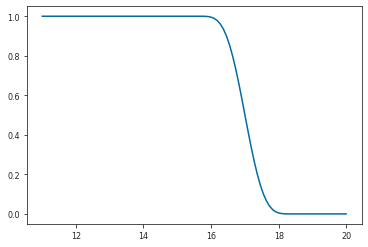

In [147]:
import numpy as np
from scipy.special import comb

def smoothstep(x, x_min=18.5, x_max=15.5, N=5):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)

    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n

    result *= x ** (N + 1)

    return result


xs = np.linspace(11, 20, 100)
ys = smoothstep(xs)
plt.plot(xs, ys)

In [148]:
smoothstep(16.5)

0.8779149519890395

In [7]:
def P_det(f, t):
    P = 1
    for i, r in observed.iterrows():
        if r.Event == 'IC160731A' and r.Class == 'HESE':
            continue
        P *= 1 - r.Signalness * r[f'{t} coverage']/100 * f
    return P

fs = np.linspace(0, 1, 1000)
Ps = {t: [P_det(f, t) for f in fs] for t in ['1h', '2h', '4h', '24h', '14d']}

inverse_pdet = {t: interp1d(iPs, fs) for t, iPs in Ps.items()}

cl = 0.9
pval = 1-cl

ul = {t: ip(pval) for t, ip in inverse_pdet.items()} 
for t, iul in ul.items():
    print(f'{t}: Only {iul*100:.1f}% ({cl*100:.0f}% CL) can lie above our limiting magnitude.')

1h: Only 59.2% (90% CL) can lie above our limiting magnitude.
2h: Only 39.3% (90% CL) can lie above our limiting magnitude.
4h: Only 34.5% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
14d: Only 10.3% (90% CL) can lie above our limiting magnitude.


In [8]:
with open("data/asassn_ul.pkl", "wb") as f:
    pickle.dump(ul, f)

In [7]:
# repeat the same but cut all with area bigger than 50 sqd

ic16mask = (alerts.Event == 'IC160731A') & (alerts.Class == 'HESE')
hese_mask = alerts.Class == 'HESE'
m = alerts.observed #& ~ic16mask &~ hese_mask

unc = {k: np.array([tuple(l[f'{k} Unc (rectangle) float']) if not ((l.Event == 'IC190629A') and (k == 'RA'))
                   else [-np.pi, np.pi]
                   for i, l in observed.iterrows()])
        for k in ['RA', 'Dec']
}

perc = observed['14d coverage']
delta = {k: (iunc.T + np.array(observed[k])).T
        for k, iunc in unc.items()}

dra = abs(delta['RA'][:,1] - delta['RA'][:,0])
dsindec = abs(np.sin(np.radians(delta['Dec'][:,1])) - np.sin(np.radians(delta['Dec'][:,0])))
areas = 180/np.pi * dra * dsindec * perc/100
observed['area'] = areas

/tmp/ipykernel_274968/3968843507.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed['area'] = areas


In [8]:
def P_det_a(f, t):
    P = 1
    for i, r in observed.iterrows():
        if r.Event == 'IC160731A' and r.Class == 'HESE':
            continue
        if r.area > 50:
            continue
        P *= 1 - r.Signalness * r[f'{t} coverage']/100 * f
    return P

fs_a = np.linspace(0, 1, 1000)
Ps_a = {t: [P_det_a(f, t) for f in fs_a] for t in ['2h', '24h', '14d']}

inverse_pdet_area_cut = {t: interp1d(iPs, fs_a) for t, iPs in Ps_a.items()}

cl = 0.9
pval = 1-cl

ul_a = {t: ip(pval) for t, ip in inverse_pdet_area_cut.items()} 
for t, iul in ul_a.items():
    print(f'{t}: Only {iul*100:.1f}% ({cl*100:.0f}% CL) can lie above our limiting magnitude. {(1-ul[t]/iul)*100:.2f}% difference')

observed[observed.area > 50]

2h: Only 40.2% (90% CL) can lie above our limiting magnitude. 2.31% difference
24h: Only 16.6% (90% CL) can lie above our limiting magnitude. 7.77% difference
14d: Only 11.4% (90% CL) can lie above our limiting magnitude. 9.69% difference


,Event,Class,RA,RA Unc (rectangle),Dec,Dec Unc (rectangle),arrival time [UT],Signalness,initial RA,initial Dec,...,6d coverage,7d coverage,14d coverage,observed,controll_Event,Before,After,closest_obs,closest_obs_side,area
60,IC200410A,BRONZE,242.58,"[14.05, -13.35]",11.61,"[7.87, -6.21]",2020-04-10 23:19:55.48,0.30535,241.2657,11.5850,...,94.6,100.0,100.0,True,IC200410A,12.65088,10.435200,10.435200,After,375.787193
63,IC200523A,BRONZE,338.64,"[10.77, -6.07]",1.75,"[1.84, -3.54]",2020-05-23 02:30:07.59,0.24998,338.9127,2.1494,...,100.0,100.0,100.0,True,IC200523A,1.25843,23.130130,1.258430,Before,90.554747
68,IC200911A,BRONZE,51.11,"[4.42, -11.01]",38.11,"[2.35, -1.99]",2020-09-11 14:19:46.23,0.40813,42.1700,38.1328,...,100.0,100.0,100.0,True,IC200911A,3.74551,0.032583,0.032583,After,52.548170
75,IC201120A,BRONZE,307.53,"[5.34, -5.59]",40.77,"[4.97, -2.8]",2020-11-20 09:44:40.55,0.50338,307.8471,40.1903,...,100.0,100.0,100.0,True,IC201120A,4.44828,15.278760,4.448280,Before,63.207542
79,IC210503A,BRONZE,143.53,"[7.71, -5.16]",41.81,"[5.02, -5.68]",2021-05-03 22:19:32.96,0.41387,NaN,NaN,...,100.0,100.0,100.0,True,IC210503A,16.46070,10.662660,10.662660,After,103.019933
82,IC210608A,BRONZE,337.41,"[4.89, -11.64]",18.37,"[3.75, -3.24]",2021-06-08 03:41:00.97,0.31467,337.0182,18.6470,...,100.0,100.0,100.0,True,IC210608A,15.47480,3.715840,3.715840,After,109.425636


In [28]:
sum(observed.area > 50)

6

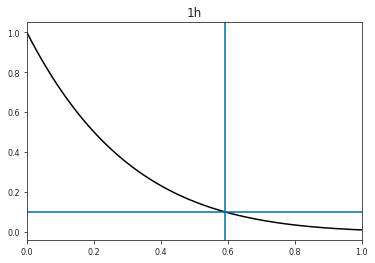

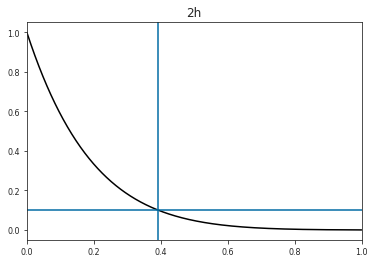

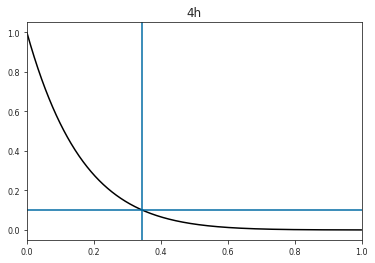

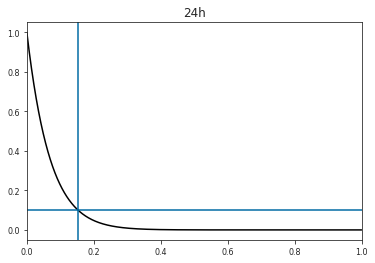

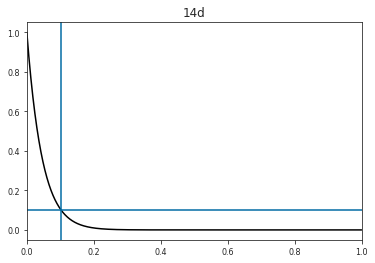

In [150]:
for t, iPs in Ps.items():
    fig, ax = plt.subplots()#figsize=(base_width, base_height), dpi=dpi)
    ax.plot(fs, iPs, color='k')
    plt.axhline(pval)
    plt.axvline(ul[t])
    # plt.yscale('log')
    ax.set_xlim((0, 1))
    ax.set_title(t)
    plt.show()
    plt.close()

In [9]:
rates = [
    #("TDE", get_rate("tde")),
    ("GRB", get_rate("GRB")),
#     ("TDE (Jetted)", get_rate("tde", rate_name="sun_15_jetted")),
    #("CCSN (Madau)", get_rate("ccsn", rate_name="madau_14", evolution_name="madau_14", kcc_name="madau_14")),
    ("SFR", get_rate("ccsn", rate_name="strolger_15", evolution_name="strolger_15", kcc_name="strolger_15")),
]

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

colors = {
    "TDE": CB_color_cycle[0],
    "GRB": CB_color_cycle[1],
    "CCSN (Madau)": CB_color_cycle[3],
    "CCSN (Strolger)": CB_color_cycle[5],
    "CCSN": CB_color_cycle[5],
    "SFR": CB_color_cycle[5]
}

In [5]:
nsteps = 1e3
zrange, step = np.linspace(0.0, 10, int(nsteps + 1), retstep=True)
zplot = 0.5*(zrange[1:] + zrange[:-1])
dlum_plot = cosmo.luminosity_distance(zplot)

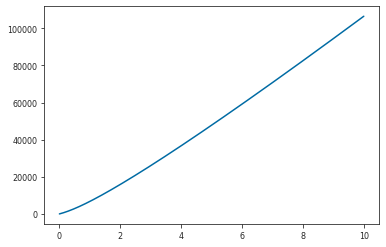

In [9]:
plt.plot(zplot, dlum_plot)

In [7]:
dlum_plot[-1]

<Quantity 106493.81377908 Mpc>

In [10]:
nsteps = 1e3
zrange, step = np.linspace(0.0, 10, int(nsteps + 1), retstep=True)
cdf_mpc = dict()
zplot = 0.5*(zrange[1:] + zrange[:-1])
dlum_plot = cosmo.luminosity_distance(zplot)

for label, rate in rates:
    
    rate_per_z, nu_flux_per_z, nu_flux_per_source, cumulative_nu_flux = \
            define_cosmology_functions(rate, 1., gamma=2.0)

    y = [x.value for x in cumulative_nu_flux(8.)]
    y = np.array(y)/y[-1]
    dls = [0.] + [dl.value for dl in dlum_plot]
    cdf_mpc[label] = interp1d(dls, [0.] + list(y))

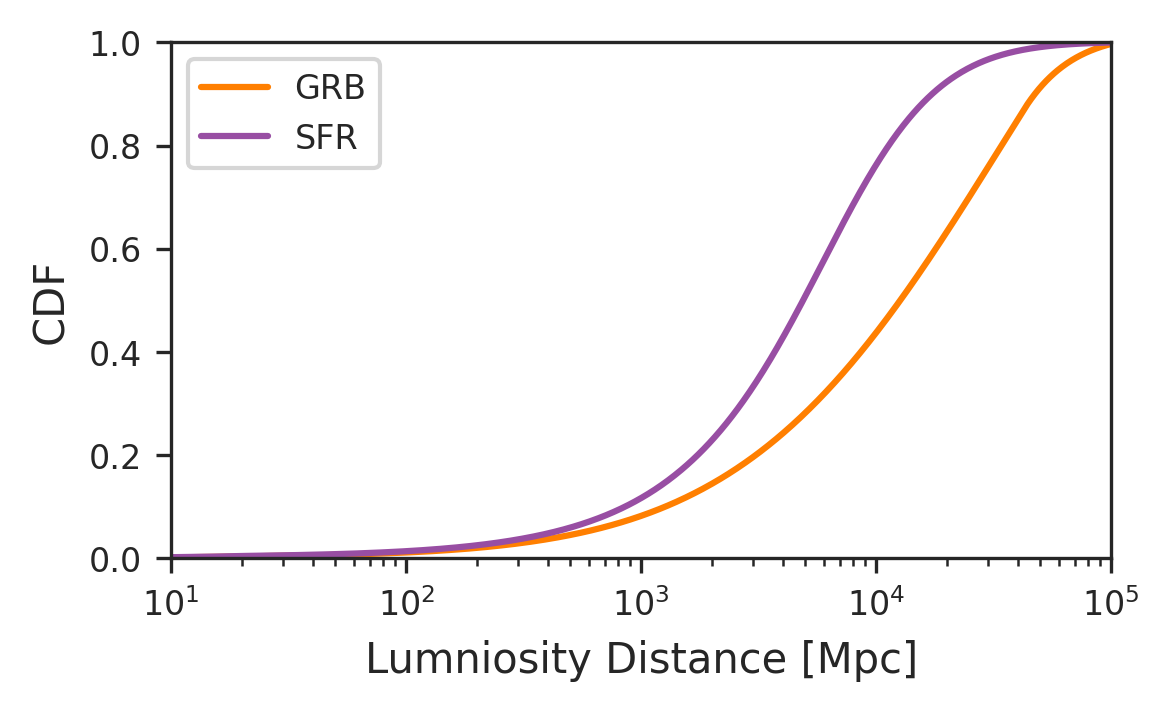

In [12]:
fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)

loglum_range = (1, 5)
dlum_plot2 = np.logspace(loglum_range[0], loglum_range[1], 1000)
for label, cdf in cdf_mpc.items():
    ax.plot(dlum_plot2, cdf(dlum_plot2), label=label, color=colors[label])
    
ax.set_xscale('log')
ax.set_ylim([0, 1])
ax.set_xlim([10**loglum_range[0], 10**loglum_range[1]])
ax.legend()
ax.set_ylabel('CDF')
ax.set_xlabel('Lumniosity Distance [Mpc]')
fig.tight_layout()
fig.savefig(f"{output_folder}/neutrino_cdfs.pdf")
plt.show()
plt.close()

In [11]:
def abs_mag(z, lim_mag):
    
    dl = cosmo.luminosity_distance(z=z).to(u.pc)
    
    ab_mag = lim_mag - 5. * np.log10(dl/(10.*u.pc))
    
    return ab_mag.value

def max_dl(ab_mag, lim_mag):
    
    dl = (10.**(0.2*(lim_mag - ab_mag))) * (10.*u.pc)
    
    return dl.to(u.Mpc)

def abs_mag_to_lum(ab_mag, wl):
    am = (ab_mag * u.ABmag).to(u.Jansky)
    f = (constants.c / wl).to("Hz")
    lum = (am * f * (4. * np.pi * (10. * u.pc)**2.)).to("erg s-1")
    return lum

In [14]:
abs_mag(0.93, 5.7)

-38.243286250993734

In [15]:
def tde_luminosity(L, min_lum):
    N_0 = 1
    L_0 = 1e43 # u.erg/u.s
    a = -1.3
    def integrand(l):
        return (l / L_0) ** a
    
    norm = quad(integrand, min_lum.to('erg/s').value, 1e48)[0]
    F = np.array([quad(integrand, min_lum.to('erg/s').value, il.to('erg/s').value)[0] for il in L])  / norm 
    return F
    

def get_lumf(rate, luminosities, **kwargs):
    lf = {'TDE': tde_luminosity}
    return lf[rate](luminosities, **kwargs)

/tmp/ipykernel_55237/1680770258.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  norm = quad(integrand, min_lum.to('erg/s').value, 1e48)[0]
/tmp/ipykernel_55237/1680770258.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  F = np.array([quad(integrand, min_lum.to('erg/s').value, il.to('erg/s').value)[0] for il in L])  / norm


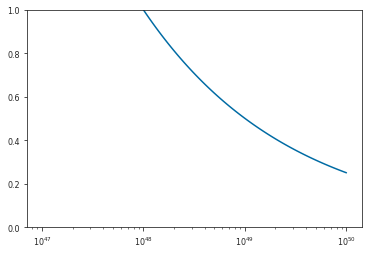

In [16]:
l = np.logspace(47, 50, 100)*u.erg/u.s
f = tde_luminosity(l, min_lum=1e40*u.erg/u.s)
plt.plot(l, f)
plt.ylim([0, 1])
plt.xscale('log')

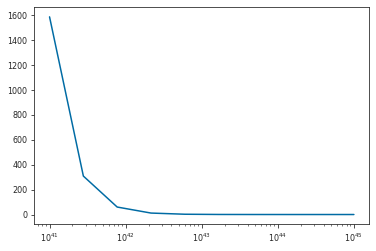

In [17]:
N_0 = 1.9e-7 * u.Mpc**3/u.yr
N_0 = 1
L_0 = 1e43 * u.erg/u.s
a = -1.6
def dN_by_dlogL(l):
    return (l / L_0) ** a * N_0

llums = np.logspace(41, 45, 10) *u.erg/u.s
rate = dN_by_dlogL(llums)
plt.plot(llums, rate)
# plt.yscale('log')
plt.xscale('log')

In [18]:
llums

<Quantity [1.00000000e+41, 2.78255940e+41, 7.74263683e+41, 2.15443469e+42,
           5.99484250e+42, 1.66810054e+43, 4.64158883e+43, 1.29154967e+44,
           3.59381366e+44, 1.00000000e+45] erg / s>

In [12]:
average_absolute_magnitudes = {
    'TDE': -19.5,
    'SN IIn': -18.53
#     'SN Ib': -17.45,
#     'SN Ic': -17.66,
    
}

mags_labels = {
    'SN IIn': 'CCSN',
    'TDE': 'TDE'
}

mag_label_map = np.array([
    ('SN IIn', 'CCSN'),
    ('TDE', 'TDE'),
    ('GRB', 'GRB'),
    ('SN IIn', 'SFR')
])

In [20]:
cdf_mpc.keys()

dict_keys(['GRB', 'SFR'])

SFR: 137.21% over -22 at 14d
GRB: 46.45% over -27 at 24h
GRB: 119.26% over -27 at 2h


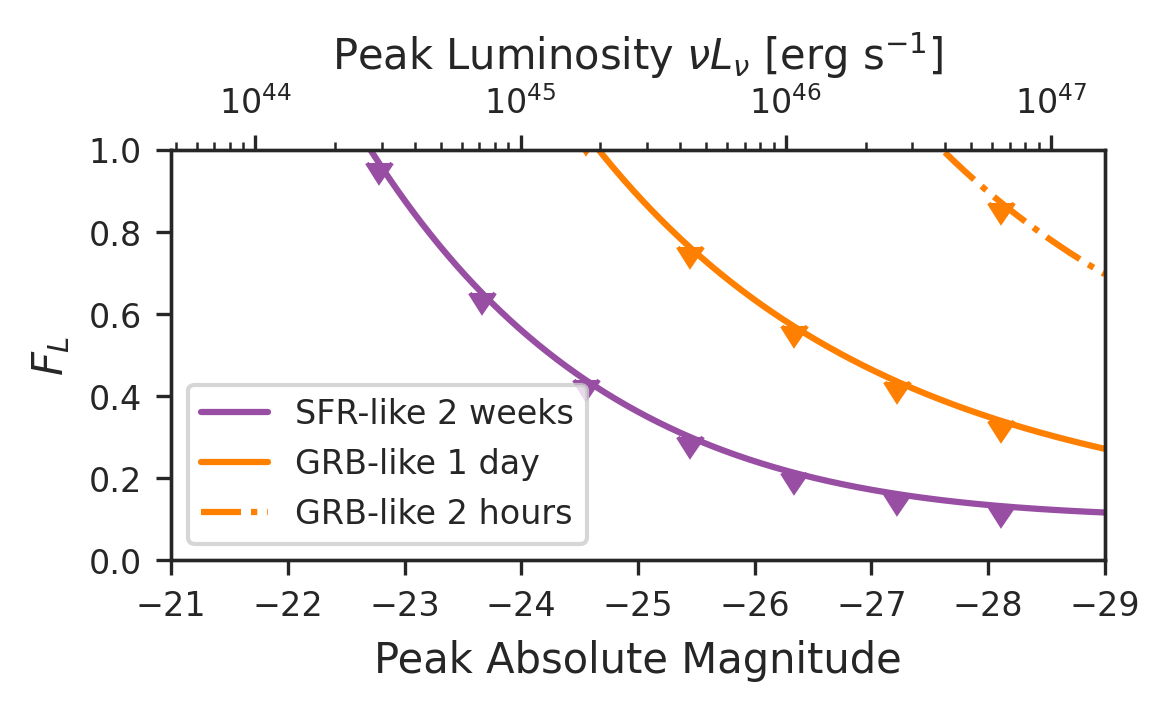

In [22]:
wl = 470*u.nm
lim_mag = {'2h': 17, '24h': 17, '14d': 17}

ls = {'2h': '--', '14d': '-'}
a = {'2h': 0.5, '14d': 1}

time_to_use = {
    "GRB": ['24h', '2h'],
    "SFR": ["14d"]
}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "SFR": "SFR-like"
}

average_absolute_magnitudes = {
#     'TDE': -19.5,
    'SN IIn': -22,
#     'CCSN': -18.53,
    'GRB': -27
}

maxfs = dict()


fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
abs_mag = np.linspace(-21, -29, 1000)

for i, rate in enumerate(["SFR", "GRB"]):

    f = cdf_mpc[rate]
    for iti, ti in enumerate(time_to_use[rate]):
        iul = ul[ti]
        def max_f(abs_mags):
            res = iul/f(max_dl(abs_mags, lim_mag[ti]))
            return res

        tistr = {
            '24h': '1 day',
            '14d': '2 weeks',
            '2h': '2 hours'
        }[ti]
        l = labels[rate] + ' ' + tistr
        ls = ['-', '-.'][iti]
        ax.plot(abs_mag, max_f(abs_mag), label=l, color=colors[rate], ls=ls)
        factor = np.random.normal(1, scale=0.1)
        mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
        eb = ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.0, uplims=True, color=colors[rate], linestyle="",
                    capsize=0, mew=1)

        tr = np.array(list(mags_labels.keys()))[np.array(list(mags_labels.values())) == rate]
        #if len(tr) == 0:
         #   continue
        Mag = average_absolute_magnitudes[mag_label_map[:,0][mag_label_map[:,1] == rate][0]]
        print(f"{rate}: {max_f(Mag)*100:.2f}% over {Mag} at {ti}")

#for t, ils in ls.items():
#    ax.plot([],[], label=t, ls=ils, color='grey')        

# for tr, Mag in average_absolute_magnitudes.items():
#     if "TDE" in tr:
#         continue
#     ax.axvline(Mag, label=tr, color=colors[mag_label_map[:,1][mag_label_map[:,0] == tr][0]], ls='dotted')

    
ax.set_xlim((max(abs_mag), min(abs_mag)))
ax2 = ax.twiny()
ax2.plot(abs_mag_to_lum(abs_mag, wl), max_f(abs_mag), ls='')
ax2.set_xscale('log')
ax.set_ylim((0, 1))
ax.legend(ncol=1)

ax.set_xlabel('Peak Absolute Magnitude')
ax2.set_xlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
fig.savefig(f"{output_folder}/limits_{cl*100:.0f}cl_notde.pdf")
plt.show()
plt.close()

SFR: 87.69% over -22 at 14d
GRB: 34.97% over -27 at 24h
GRB: 89.78% over -27 at 2h


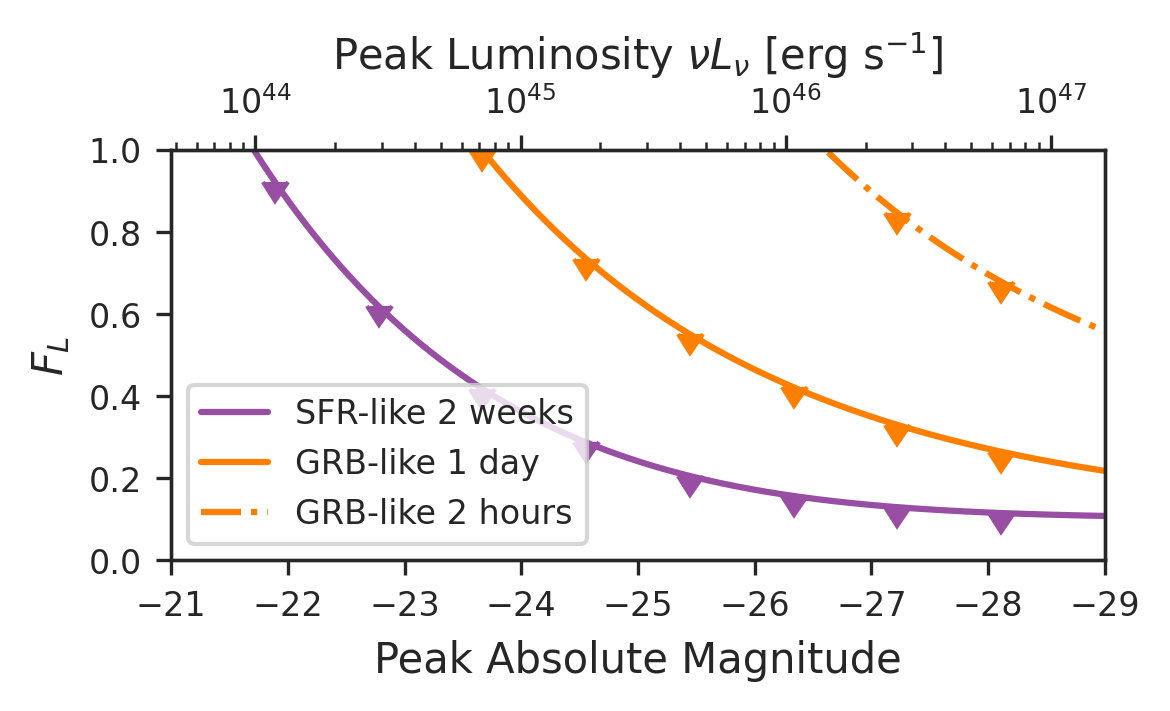

In [23]:
wl = 470*u.nm
lim_mag = {'2h': 18, '24h': 18, '14d': 18}

ls = {'2h': '--', '14d': '-'}
a = {'2h': 0.5, '14d': 1}

time_to_use = {
    "GRB": ['24h', '2h'],
    "SFR": ["14d"]
}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "SFR": "SFR-like"
}

average_absolute_magnitudes = {
#     'TDE': -19.5,
    'SN IIn': -22,
#     'CCSN': -18.53,
    'GRB': -27
}

maxfs = dict()


fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
abs_mag = np.linspace(-21, -29, 1000)

for i, rate in enumerate(["SFR", "GRB"]):

    f = cdf_mpc[rate]
    for iti, ti in enumerate(time_to_use[rate]):
        iul = ul[ti]
        def max_f(abs_mags):
            res = iul/f(max_dl(abs_mags, lim_mag[ti]))
            return res

        tistr = {
            '24h': '1 day',
            '14d': '2 weeks',
            '2h': '2 hours'
        }[ti]
        l = labels[rate] + ' ' + tistr
        ls = ['-', '-.'][iti]
        ax.plot(abs_mag, max_f(abs_mag), label=l, color=colors[rate], ls=ls)
        factor = np.random.normal(1, scale=0.1)
        mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
        eb = ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.0, uplims=True, color=colors[rate], linestyle="",
                    capsize=0, mew=1)

        tr = np.array(list(mags_labels.keys()))[np.array(list(mags_labels.values())) == rate]
        #if len(tr) == 0:
         #   continue
        Mag = average_absolute_magnitudes[mag_label_map[:,0][mag_label_map[:,1] == rate][0]]
        print(f"{rate}: {max_f(Mag)*100:.2f}% over {Mag} at {ti}")

#for t, ils in ls.items():
#    ax.plot([],[], label=t, ls=ils, color='grey')        

# for tr, Mag in average_absolute_magnitudes.items():
#     if "TDE" in tr:
#         continue
#     ax.axvline(Mag, label=tr, color=colors[mag_label_map[:,1][mag_label_map[:,0] == tr][0]], ls='dotted')

    
ax.set_xlim((max(abs_mag), min(abs_mag)))
ax2 = ax.twiny()
ax2.plot(abs_mag_to_lum(abs_mag, wl), max_f(abs_mag), ls='')
ax2.set_xscale('log')
ax.set_ylim((0, 1))
ax.legend(ncol=1)

ax.set_xlabel('Peak Absolute Magnitude')
ax2.set_xlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
fig.savefig(f"{output_folder}/limits_{cl*100:.0f}cl_notde.pdf")
plt.show()
plt.close()

SFR V: 213.44% over -22 at 14d
GRB V: 63.43% over -27 at 24h
GRB V: 162.85% over -27 at 2h
SFR g: 137.21% over -22 at 14d
GRB g: 46.45% over -27 at 24h
GRB g: 119.26% over -27 at 2h


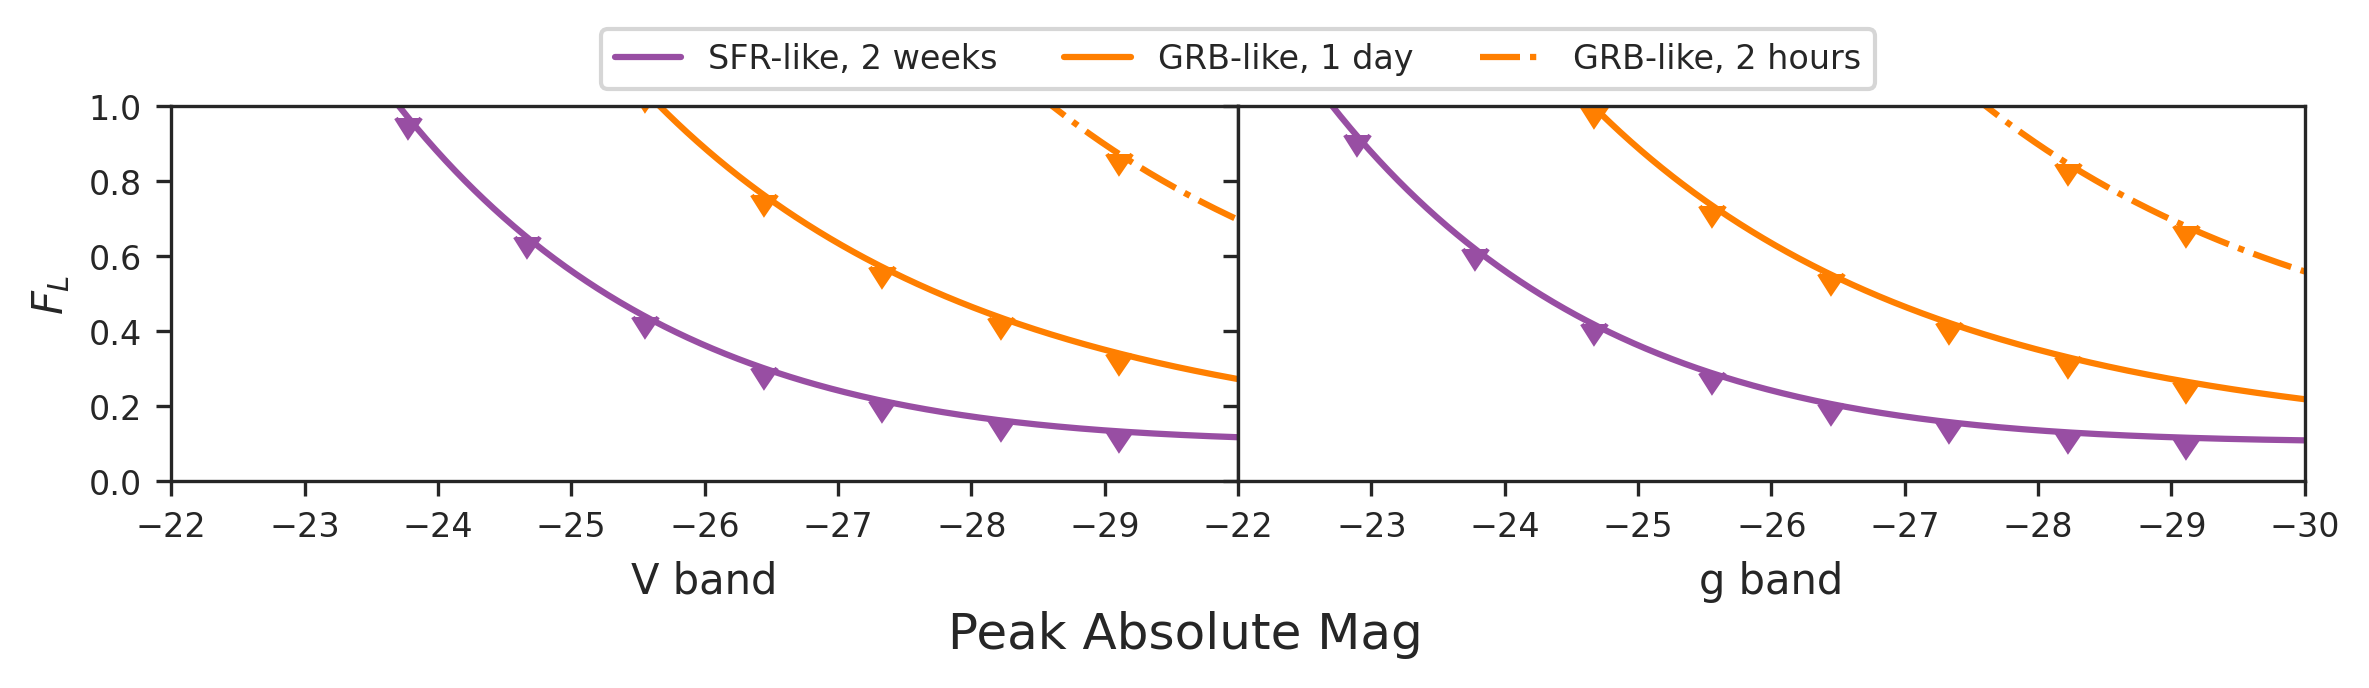

In [14]:
wl = 470*u.nm
lim_mag = {
    'V': {'2h': 16, '24h': 16, '14d': 16},
    'g': {'2h': 17, '24h': 17, '14d': 17}
}

ls = {'2h': '--', '14d': '-'}
a = {'2h': 0.5, '14d': 1}

time_to_use = {
    "GRB": ['24h', '2h'],
    "SFR": ["14d"]
}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "SFR": "SFR-like"
}

average_absolute_magnitudes = {
#     'TDE': -19.5,
    'SN IIn': -22,
#     'CCSN': -18.53,
    'GRB': -27
}

maxfs = dict()


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(base_width*2, base_height*1.1), dpi=dpi, sharey='all',
                      gridspec_kw={'wspace': 0})
abs_mag_band = {
    'V': np.linspace(-22, -30, 1000),
    'g': np.linspace(-22, -30, 1000)
}

for iband, (ax, band) in enumerate(zip(axs, ['V', 'g'])):
    abs_mag = abs_mag_band[band]

    for i, rate in enumerate(["SFR", "GRB"]):

        f = cdf_mpc[rate]
        for iti, ti in enumerate(time_to_use[rate]):
            iul = ul[ti]
            def max_f(abs_mags):
                res = iul/f(max_dl(abs_mags, lim_mag[band][ti]))
                return res

            tistr = {
                '24h': '1 day',
                '14d': '2 weeks',
                '2h': '2 hours'
            }[ti]
            l = labels[rate] + ', ' + tistr
            ls = ['-', '-.'][iti]
            ax.plot(abs_mag, max_f(abs_mag), label=l, color=colors[rate], ls=ls)
            factor = np.random.normal(1, scale=0.1)
            mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
            eb = ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.0, uplims=True, color=colors[rate], linestyle="",
                        capsize=0, mew=1)

            tr = np.array(list(mags_labels.keys()))[np.array(list(mags_labels.values())) == rate]
            #if len(tr) == 0:
             #   continue
            Mag = average_absolute_magnitudes[mag_label_map[:,0][mag_label_map[:,1] == rate][0]]
            print(f"{rate} {band}: {max_f(Mag)*100:.2f}% over {Mag} at {ti}")

    #for t, ils in ls.items():
    #    ax.plot([],[], label=t, ls=ils, color='grey')        

    # for tr, Mag in average_absolute_magnitudes.items():
    #     if "TDE" in tr:
    #         continue
    #     ax.axvline(Mag, label=tr, color=colors[mag_label_map[:,1][mag_label_map[:,0] == tr][0]], ls='dotted')

    
    Nticks = max(abs_mag) - min(abs_mag) + 1
    
    _s = max(abs_mag)
    _e = min(abs_mag) 
    if iband == 0:
        _e += 1
        Nticks -= 1
    
    xticks = np.linspace(_s, _e, num=int(Nticks))
    ax.set_xticks(xticks)
    ax.set_xlim((max(abs_mag), min(abs_mag)))
    #ax2 = ax.twiny()
    #ax2.plot(abs_mag_to_lum(abs_mag, wl), max_f(abs_mag), ls='')
    #ax2.set_xscale('log')
    ax.set_ylim((0, 1))
    #ax.legend(ncol=1)

    ax.set_xlabel(f'{band} band')
    #ax2.set_xlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]')
axs[0].set_ylabel('$F_{L}$')
axs[0].legend(bbox_to_anchor = (1,1.25), ncol=3, loc='upper center')
    
fig.supxlabel('Peak Absolute Mag', y=0.1)
#fig.supxlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]', x=0.5, y=0.8)
fig.tight_layout()
#fig.savefig(f"{output_folder}/limits_{cl*100:.0f}cl_notde_separate_bands.pdf")
plt.show()
plt.close()

In [70]:
xticks

array([], dtype=float64)

KeyError: '1h'

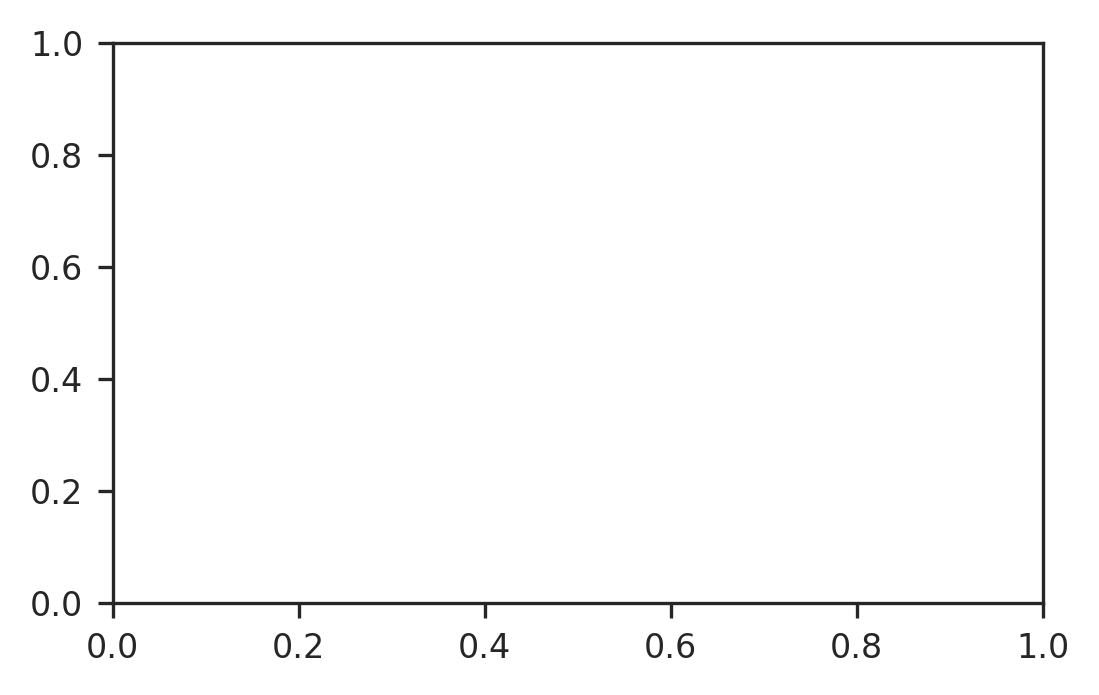

In [21]:
lim_mag = {'1d': 18.5, '14d': 18.5}

wl = 470*u.nm

xlim = {'1d': (-19, -27), '14d': (-15, -24)}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

maxfs = dict()

for t, iul in ul.items():

    fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
    xl = xlim[t]
    abs_mag = np.linspace(max(xl), min(xl), 1000)
    ax2 = ax.twiny()

    for i, rate in enumerate(["CCSN (Strolger)", "GRB"]):
        f = cdf_mpc[rate]

        def max_f(abs_mags):
            res = iul/f(max_dl(abs_mags, lim_mag[t]))
            return res

        ax.plot(abs_mag, max_f(abs_mag), label=labels[rate], color=colors[rate])
        mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
        ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.04, uplims=True, color=colors[rate], linestyle=" ")
        
#         if rate == 'TDE':
#             ax.plot(abs_mag, get_lumf(rate, abs_mag_to_lum(abs_mag, wl), **{'min_lum': 1e40*u.erg/u.s}))

    for tr, Mag in average_absolute_magnitudes.items():
        ax.axvline(Mag, label=tr, color=colors[mags_labels[tr]], ls='dotted')
        
    ax.set_xlim((max(abs_mag), min(abs_mag)))
    ax2.plot(abs_mag_to_lum(abs_mag, wl), max_f(abs_mag), ls='')
    ax2.set_xscale('log')
    ax.set_ylim((0, 1))
    ax.legend(ncol=2, loc='upper right')
    


    ax.set_xlabel('Peak Absolute Magnitude')
    ax2.set_xlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]')
    ax.set_ylabel('$F_{L}$')
    fig.savefig(f"{output_folder}/limits{t}_{cl*100:.0f}cl.pdf")
    
    plt.show()
    plt.close()

KeyError: 'TDE'

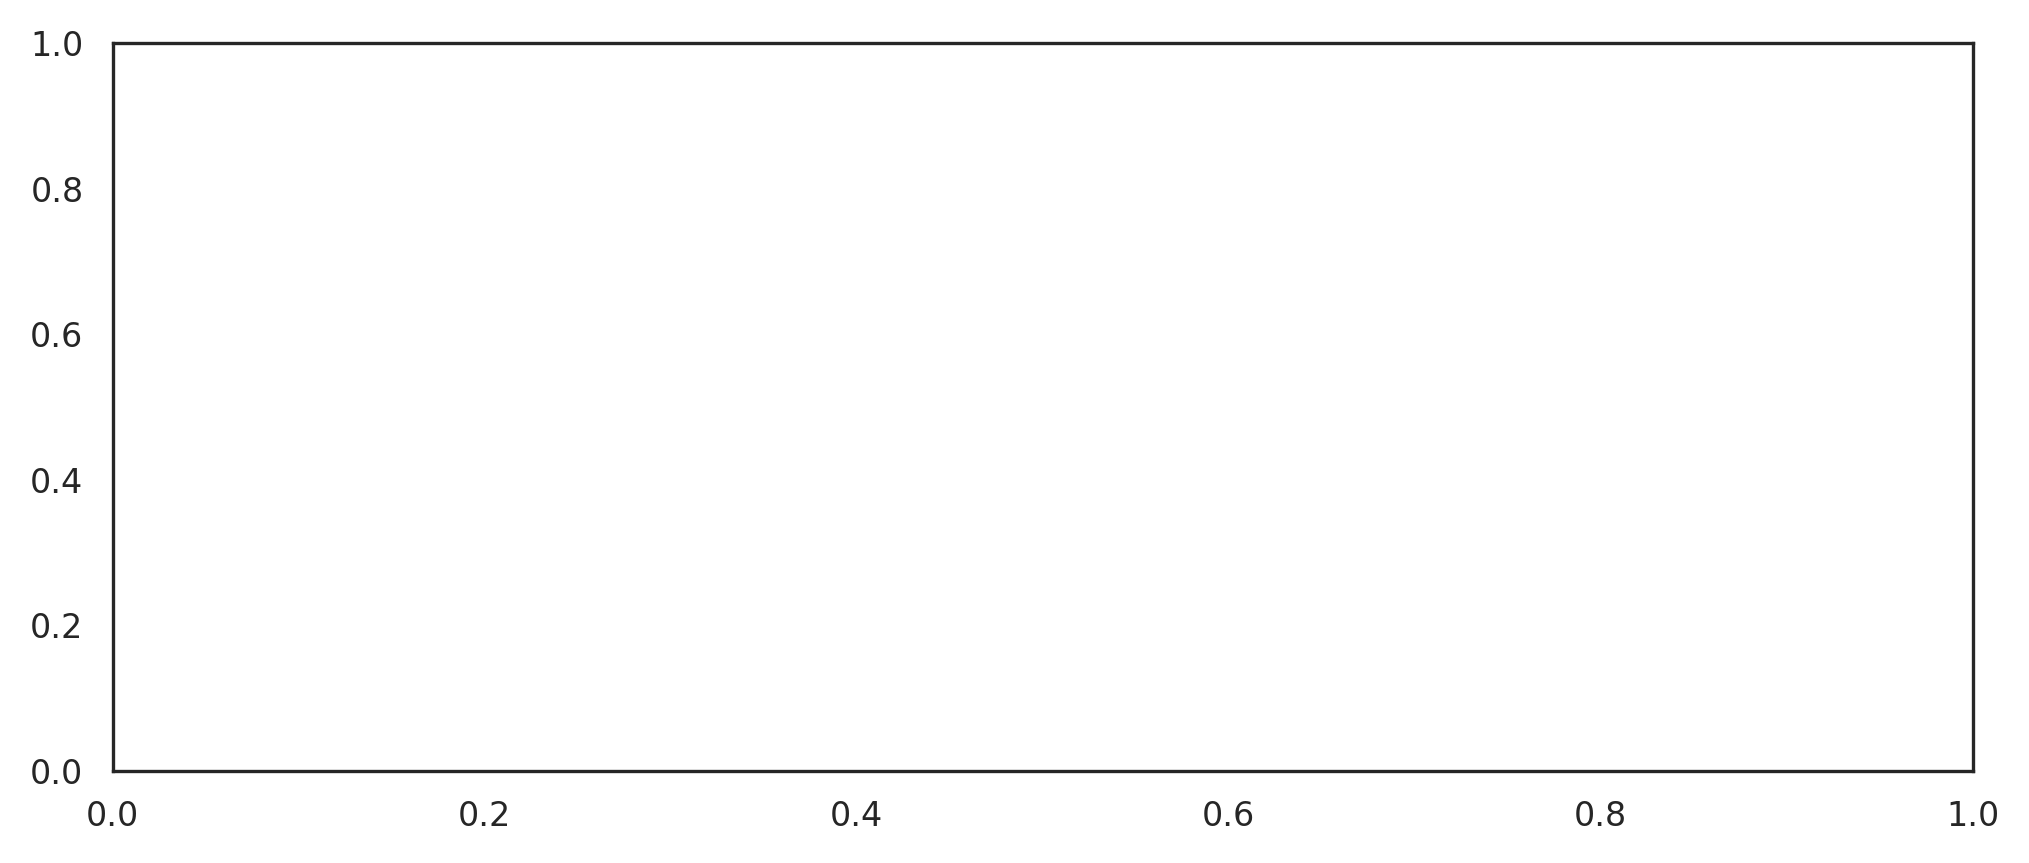

In [69]:
wl = 470*u.nm

ls = {'2h': '--', '14d': '-'}
a = {'2h': 0.5, '14d': 1}

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

maxfs = dict()


fig, ax = plt.subplots(figsize=(base_width*2, base_height*1.3), dpi=dpi)
abs_mag = np.linspace(np.max(list(xlim.values())), np.min(list(xlim.values())), 1000)

for i, rate in enumerate(["TDE", "CCSN (Strolger)", "GRB"]):

    for t, iul in ul.items():

        f = cdf_mpc[rate]

        def max_f(abs_mags):
            res = iul/f(max_dl(abs_mags, lim_mag[t]))
            return res

        l = labels[rate] if t=='14d' else ''
        ax.plot(abs_mag, max_f(abs_mag), label=l, color=colors[rate], ls=ls[t])
        factor = np.random.normal(1, scale=0.1)
        mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
        eb = ax.errorbar(mag_scatter, max_f(mag_scatter), yerr=0.0, uplims=True, color=colors[rate], linestyle="",
                    capsize=0, mew=1)
        
        tr = np.array(list(mags_labels.keys()))[np.array(list(mags_labels.values())) == rate]
        if len(tr) == 0:
            continue
        Mag = average_absolute_magnitudes[tr[0]]
        print(f"{rate} {tr[0]}: {max_f(Mag)}% over {Mag}")

for t, ils in ls.items():
    ax.plot([],[], label=t, ls=ils, color='grey')        

for tr, Mag in average_absolute_magnitudes.items():
    ax.axvline(Mag, label=tr, color=colors[mags_labels[tr]], ls='dotted')

    
ax.set_xlim((max(abs_mag), min(abs_mag)))
ax2 = ax.twiny()
ax2.plot(abs_mag_to_lum(abs_mag, wl), max_f(abs_mag), ls='')
ax2.set_xscale('log')
ax.set_ylim((0, 1))
ax.legend(ncol=3)

ax.set_xlabel('Peak Absolute Magnitude')
ax2.set_xlabel('Peak Luminosity $\\nu L_{\\nu}$ [erg s$^{-1}$]')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
fig.savefig(f"{output_folder}/limits_{cl*100:.0f}cl.pdf")
plt.show()
plt.close()

In [39]:
np.array(list(mags_labels.values())) == rate

array([False,  True])

In [143]:
import tarfile

In [144]:
with tarfile.open('data/1006.4612', 'r') as tar:
    tar.extractall('data/sn_lf')

In [15]:
output_folder

'../figures/'

In [15]:
a = -0.33

In [16]:
a + 8

7.67

In [17]:
float("-0.33")

-0.33

In [18]:
"-" == "-"

True